In [42]:
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt

In [3]:
trips_df = pd.read_pickle('../00_data/trips.pkl')
stations_df = pd.read_pickle('../00_data/stations.pkl')
stations_df = stations_df.set_index("station_id")

In [4]:
station_ids = np.unique(
    np.concatenate([trips_df["start_station_id"], trips_df["end_station_id"]])
)

In [5]:
dates = pd.date_range(start='2019-01-01', end='2019-12-31', freq='h')

In [6]:
full_index = pd.MultiIndex.from_product([station_ids, dates], names=['station_id', 'date'])

In [7]:
trips_df["start_time_floored"] = trips_df["start_time"].dt.floor("h")
trips_per_station_date = trips_df.groupby(
    ["start_station_id", "start_time_floored"]
).size()
trips_per_station_date = (
    trips_per_station_date.reindex(full_index).fillna(0).to_frame("n_trips")
)


In [8]:
time_interval = pd.date_range(start='2019-12-01', end='2019-12-31', freq='H')

trips_per_station_date.loc[(slice(None), time_interval), :].index.get_level_values(0).nunique()

148

In [9]:
def get_station_utilization(time_interval):
    station_utilization = trips_per_station_date.loc[(slice(None), time_interval), :]
    station_utilization = (
        station_utilization[station_utilization["n_trips"] != 0]
        .groupby(level=[0])
        .count()
    )
    station_utilization = station_utilization.reindex(station_ids).fillna(0)
    station_utilization = station_utilization.rename(columns={'n_trips': 'days_used'})
    station_utilization['station_usage'] = station_utilization['days_used'] / len(time_interval)
    return station_utilization

In [10]:
def get_n_underutilized_stations(station_utilization, threshold):
    station_utilization_kpi = len(station_utilization[
        station_utilization["station_usage"] < threshold
    ])
    return station_utilization_kpi

def get_n_unused_stations(station_utilization, threshold):
    return len(station_utilization[station_utilization["station_usage"] == 0])


In [11]:
def print_utilization_summary(station_utilization, threshold):
    n_underutilized_stations = get_n_underutilized_stations(
        station_utilization, threshold
    )
    n_unused_stations = get_n_unused_stations(station_utilization, threshold)
    print(
        f"{n_underutilized_stations} ({n_underutilized_stations/len(station_utilization) * 100:.2f}%) stations are underutilized"
    )
    print(
        f"{get_n_unused_stations(station_utilization, threshold)} ({n_unused_stations/len(station_utilization) * 100:.2f}%) stations are unused"
    )


In [39]:
station_utilization = get_station_utilization(
    pd.date_range(start="2019-12-04 00:00", end="2019-12-04 23:59", freq="h")
)
print_utilization_summary(station_utilization, threshold=0.2)

124 (83.78%) stations are underutilized
57 (38.51%) stations are unused


In [23]:


utilization_over_year = pd.date_range(
    start="2019-01-01", end="2019-12-31", freq="d"
)
# print all methods of the object 
(utilization_over_year[0].floor("h"))

Timestamp('2019-01-01 00:00:00')

In [37]:
utilization_over_year = pd.date_range(
    start="2019-01-01", end="2019-12-31", freq="d"
).to_frame(name="date")

station_utilization
for index, row in utilization_over_year.iterrows():
	start = row['date'].floor("h")
	end = (row['date'] + pd.Timedelta(hours=23)).floor("h")


	station_utilization = pd.date_range(start, end, freq="h")
	station_utilization = get_station_utilization(
        pd.date_range(start, end, freq="h")
    )

	utilization_over_year.loc[index, "unused_stations"] = get_n_unused_stations(
		station_utilization, threshold=0.2
	)
	utilization_over_year.loc[index, "underutilized_stations"] = get_n_underutilized_stations(
		station_utilization, threshold=0.2
	)
utilization_over_year = utilization_over_year.set_index("date")

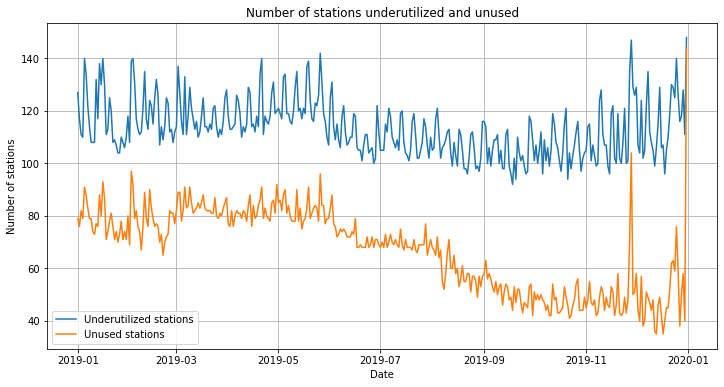

In [46]:
# plot utilization over year
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(utilization_over_year.index, utilization_over_year["underutilized_stations"])
ax.plot(utilization_over_year.index, utilization_over_year["unused_stations"])
ax.legend(["Underutilized stations", "Unused stations"])
ax.set_xlabel("Date")
ax.set_ylabel("Number of stations")
ax.set_title("Number of stations underutilized and unused")
ax.grid()
plt.show()


In [ ]:
def draw_underutilized_stations(station_utilization, threshold):
    underutilized_stations = station_utilization[
        station_utilization["station_usage"] < threshold
    ]
    stations = stations_df.loc[underutilized_stations.index]
    stations = stations.merge(underutilized_stations, left_index=True, right_index=True)
    la_map = folium.Map(
        location=(
            34.052235,
            -118.243683,
        ),  # the orig mean values as location coordinates
        zoom_start=11,
        control_scale=True,
        max_zoom=20,
    )

    for index, row in stations.iterrows():
        days_used = int(row['days_used'])
        popup = folium.Popup(
            html=f"Station ID: <b>{index}</b><br>Days used: <b>{days_used}</b>",
			max_width=100,
			min_width=100,
        )
        color = 'red' if days_used == 0 else 'orange'
        folium.Marker(
            location=[row["latitude"], row["longitude"]],
            popup=popup,
            icon=folium.Icon(color=color),
        ).add_to(la_map)

    return la_map


In [ ]:
draw_underutilized_stations(station_utilization, threshold=0.2)